# __KerasTuner para la construccion del mejor modelo__

### Cargar datos

In [1]:
# librerias
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import string
import tensorflow as tf

from tensorflow.keras import regularizers

# libreria para trabajar con las bases de datos 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-11-08 09:30:40.639398: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-08 09:30:41.557478: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-08 09:30:42.352064: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731076242.800737    6334 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731076242.876896    6334 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-08 09:30:44.301818: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

Found 27455 images belonging to 24 classes.
Found 1425 images belonging to 24 classes.
Found 7172 images belonging to 24 classes.


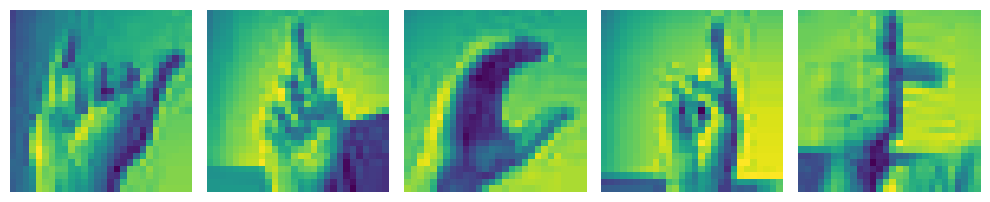

In [ ]:
# ruta de los archivos
train_dir = './sign-language-img/Train'
test_dir = './sign-language-img/Test'

# data generator
train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.2)

# generator para test, training y validation
# para datos de entrenamiento
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (28, 28),
    batch_size = 128,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subset = 'training'
)

# para datos de validacion
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (28, 28),
    batch_size = 128,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subset = 'validation'
)

# para datos de prueba
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (28, 28),
    batch_size = 128,
    class_mode = 'categorical',
    color_mode = 'grayscale'
)

# clases
classes = [char for char in string.ascii_uppercase if char != 'J' if char != 'Z']

# funcion para mostrar las imagenes
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize = (10, 10))
    axes = axes.flatten()

    for img, ax in zip(images_arr, axes):
        ax.imshow(img[:,:,0])
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# mostrar 5 imagenes
sample_training_images, _ = next(train_generator)
plotImages(sample_training_images[:5])

### Modelo a trabajar

El modelo con el que vamos a trabajar es el mismo con el que hemos venido trabajando. Vamos a definirlo

In [3]:
# funcion para generalizar la creacion del modelo
def get_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(75, (3,3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPool2D((2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, kernel_regularizer = regularizers.l2(1e-5), activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, kernel_regularizer = regularizers.l2(1e-5), activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(len(classes), activation='softmax')
    ])
    return model

### Implementando Autotuner

Vamos a cargar la libreria kerastuner y keras

In [4]:
import kerastuner as kt
from tensorflow import keras

/tmp/ipykernel_6334/2517507747.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


Para esta ocasión crearemos un nuevo constructor de modelos, este recibirá como parámetros un objeto tuner que determinará las variaciones de diferentes hiperparámetros.

- Arquitectura general, donde agregaremos una capa de convolución, Max Pooling y aplanamiento de manera fija

- Primer variable del constructor: La cantidad de neuronas en la siguiente capa oculta, se inicializará en 16 e incrementará hasta 32 dando saltos de 8 en 8.

- La capa oculta sera de 32 neuronas.

- La cantidad de neuronas de la siguiente capa será el objeto iterador. El resto de la red se mantendrá estable.

- Variaciones en el learning rate, donde empezaremos el modelo con 3 posibles learning rate: 0.01, 0.001 y 0.0001.

- Al momento de compilar el modelo definiremos Adam como optimizador, sin embargo, llamaremos directamente a la clase y le entregaremos el objeto iterador. El resto de parámetros seguirán iguales.

In [5]:
def constructor_modelos(hp):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(75, (3,3), activation='relu', input_shape = (28,28,1)))
    model.add(tf.keras.layers.MaxPool2D((2,2)))
    model.add(tf.keras.layers.Flatten())

    hp_units = hp.Int('units', min_value=8, max_value=32, step=8)
    model.add(tf.keras.layers.Dense(units=hp_units, activation='relu', kernel_regularizer=regularizers.l2(1e-5)))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-5)))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(len(classes), activation='softmax'))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(
        learning_rate=hp_learning_rate), 
        loss='categorical_crossentropy', 
        metrics=['accuracy'])
    return model

Esta función será la materia prima del tuner, el cual hará pruebas con todas las combinatorias para encontrar el modelo más optimo.

### Buscando la mejor configuracion para tu modelo

Con el generador de modelos definido podremos crear el tuner que iterará a través de la configuración expuesta.

Crearemos una instancia Hyperband (que será el objeto que iterará en las configuraciones). Sus parametros seran:

- Función generador
- Métrica objetivo (en este caso será val_accuracy para medir la precisión real del modelo)
- Máximo de 5 épocas
- factor de 2
- directorio de carga
- nombre de proyecto.

In [6]:
tuner = kt.Hyperband(
    constructor_modelos,
    objective = 'val_accuracy',
    max_epochs = 5,
    factor = 2,
    directory = './',
    project_name = 'tuner_project'
)

Reloading Tuner from ./tuner_project/tuner0.json


2024-11-08 09:31:45.920579: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Con en tuner generado, podremos empezar nuestra búsqueda. Entregamos al método:
- el dataset
- las épocas máximas
- los datos de validación

Empezamos el entrenamiento y esperamos a que se complete. Guardaremos el mejor desempeño en la variable best_hps

In [7]:
tuner.search(
    train_generator, 
    epochs=10, 
    validation_data= validation_generator
    )

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Para obtener las mejores configuraciones haremos uso del método get

In [8]:
# numero de neuronas optimas
print(best_hps.get('units'))

24


In [9]:
# tasa de aprendizaje optimo
print(best_hps.get('learning_rate'))

0.01


> El mejor modelo posee 24 neuronas y una taza de aprendizaje de 0.01

### Creando un modelo a partir de la mejor configuracion

Con los mejores hiperparámetros encontrados podremos construir un modelo optimizado, esto lo haremos con el método hypermodel.build de tuner que recibirá la configuración como argumento.

Ahora tenemos un modelo listo para ser entrenado, agregaremos el callback de early stopping para evitar sobre entrenamientos innecesarios.

In [10]:
callback_early = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=3,
    mode='auto'
)

In [11]:
hypermodel = tuner.hypermodel.build(best_hps)

history_hypermodel = hypermodel.fit(
    train_generator,
    epochs = 20,
    callbacks = [callback_early],
    validation_data = validation_generator
)

/home/jbernal/anaconda3/envs/tf_cpu/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/jbernal/anaconda3/envs/tf_cpu/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 94s 415ms/step - accuracy: 0.0998 - loss: 2.9445 - val_accuracy: 0.4056 - val_loss: 1.8174
Epoch 2/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 33s 156ms/step - accuracy: 0.3526 - loss: 1.8841 - val_accuracy: 0.4898 - val_loss: 1.5497
Epoch 3/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 46s 180ms/step - accuracy: 0.4610 - loss: 1.6039 - val_accuracy: 0.5074 - val_loss: 1.5015
Epoch 4/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 51s 239ms/step - accuracy: 0.5121 - loss: 1.4517 - val_accuracy: 0.5474 - val_loss: 1.4773
Epoch 5/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 64s 298ms/step - accuracy: 0.5442 - loss: 1.3706 - val_accuracy: 0.5298 - val_loss: 1.4433
Epoch 6/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 56s 259ms/step - accuracy: 0.5651 - loss: 1.3022 - val_accuracy: 0.5018 - val_loss: 1.5743
Epoch 7/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 49s 225ms/step - accuracy: 0.5770 - loss: 1.2643 - val_accuracy: 0.5221 - val_loss: 1.5422
Epoch 8/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 37s 170ms/step - accuracy: 0.5890 - loss: 1

> El early sttoping detecto que no estaba mejorando el modelo en cada epoca por lo que detuvo el entrenamiento en la epoca 12.

> El modelo alcanza un valor 0.0424 en accuracy de entrenamiento



# __Almacenamiento y carga del Modelo__

### Cargando y descargando arquitecturas sin pesos

Puedes usar la arquitectura de un modelo para basarte a la hora de entrenar otros modelos, esto no traerá los pesos, por lo que no será útil para realizar predicciones

Con el método get_config de tus modelos puedes adquirir un JSON completo con la información de la arquitectura de tu red.

In [12]:
config_dict = hypermodel.get_config()
print(config_dict)

{'name': 'sequential', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 28, 28, 1), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'filters': 75, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name

Para cargar un modelo con base en esta configuración bastará con usar el método from_config de los modelos secuenciales de Keras enviando como parámetro el JSON de configuración.

In [13]:
model_same_config = tf.keras.Sequential.from_config(config_dict)

Para verificar que sea la arquitectura del mismo modelo, vemos el summary

In [14]:
model_same_config.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 75)     │           750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 75)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12675)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │       304,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 24)             │           792 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 306,566 (1.17 MB)

 Trainable params: 306,566 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

### Descargando arquitecturas con pesos

Para guardar arquitecturas con pesos es necesario usar el callback de ModelCheckpoint que nos permitirá guardar en disco el modelo con sus pesos.

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint

Creamos un modelo vacio que guardaremos despues

In [16]:
model_weight = get_model()
# summary para verificar el modelo que acabamos de crear
model_weight.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 75)     │           750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 75)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12675)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     3,245,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,281,798 (12.52 MB)

 Trainable params: 3,281,798 (12.52 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model_weight.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

Crearemos la configuración para nuestro callback. Definimos el path donde se guardará el modelo, cada cuando se guardará, si solo guardará los pesos y el output de texto a recibir.

In [18]:
checkpoint_path = './model_checkpoint/checkpoint.weights.h5'

checkpoint_weight = ModelCheckpoint(
    filepath = checkpoint_path,
    save_freq = 'epoch',
    save_weights_only = True,
    verbose = 1
)

Entrenaremos el modelo sin olvidar agregar el callback.

In [19]:
history_weight = model_weight.fit(
    train_generator,
    epochs = 20,
    callbacks = [checkpoint_weight],
    validation_data = validation_generator
)

Epoch 1/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.2901 - loss: 2.4099
Epoch 1: saving model to ./model_checkpoint/checkpoint.weights.h5
215/215 ━━━━━━━━━━━━━━━━━━━━ 70s 309ms/step - accuracy: 0.2912 - loss: 2.4062 - val_accuracy: 0.7411 - val_loss: 0.7899
Epoch 2/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.8612 - loss: 0.4523
Epoch 2: saving model to ./model_checkpoint/checkpoint.weights.h5
215/215 ━━━━━━━━━━━━━━━━━━━━ 64s 228ms/step - accuracy: 0.8613 - loss: 0.4518 - val_accuracy: 0.8239 - val_loss: 0.5957
Epoch 3/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9613 - loss: 0.1575
Epoch 3: saving model to ./model_checkpoint/checkpoint.weights.h5
215/215 ━━━━━━━━━━━━━━━━━━━━ 49s 228ms/step - accuracy: 0.9613 - loss: 0.1574 - val_accuracy: 0.8372 - val_loss: 0.5971
Epoch 4/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.9828 - loss: 0.0888
Epoch 4: saving model to ./model_checkpoint/checkpoint.weights.h5
215/215 ━━━━━━━━━━━━━━━━

Con esto hemos guardado un historial entero de nuestro modelo, puedes revisarlo en el directorio model_checkpoints/checkpoint.weights.h5

Si deseas guardar manualmente los pesos de tu red lo puedes haces con el método save indicando el directorio de salida. Esta manera únicamente guardará la última iteración, por lo que si por alguna razón la red sufrió un daño en esta etapa, no podrás revertirlo (a comparación del callback que guarda el historial entero).

In [22]:
model_weight.save('./model_manual/my_model.h5')

### Cargando arquitectura con pesos

Crearemos un nuevo modelo hueco con la misma estructura que el original.

In [23]:
model_weight2 = get_model()
model_weight2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

/home/jbernal/anaconda3/envs/tf_cpu/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Para cargar el modelo desde disco nos basta con usar el método load_weights indicando la locación a cargar.

In [24]:
model_weight2.load_weights(checkpoint_path)

/home/jbernal/anaconda3/envs/tf_cpu/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Si evaluamos el desempeño del modelo original y el cargado nos daremos cuenta que son literalmente el mismo, reafirmando que el proceso de carga fue correcto.

In [ ]:
# desempeno del modelo cargado
model_weight2.evaluate(test_generator)

/home/jbernal/anaconda3/envs/tf_cpu/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57/57 ━━━━━━━━━━━━━━━━━━━━ 26s 408ms/step - accuracy: 0.8706 - loss: 0.6656


[0.6903767585754395, 0.8655884265899658]

In [26]:
# desempeno del modelo original
model_weight.evaluate(test_generator)

57/57 ━━━━━━━━━━━━━━━━━━━━ 12s 203ms/step - accuracy: 0.8738 - loss: 0.6446


[0.6903769969940186, 0.8655884265899658]

> El desempeno de ambos modelos son iguales lo que implica que la carga de los pesos se hizo correctamente

# __Criterios para almacenar los modelos__

### Mejorando el guardado de los pesos

- Definimos un path para guardar nuestro nuevo modelo.

- Cambiamos la forma en como se guarda el modelo modificando ModelCheckPoint.

    - Se cambia a False el parametro _save_weight_only_.
    - Agregamos _val_accuracy_ como monitor de desempeno.
    - Guardamos solo la mejor version del modelo.

In [ ]:
# nueva ruta
checkpoint_path = './model_checkpoint_complete/model_checkpoint_complete.keras'

# modificacion del callback
checkpoint_weight = ModelCheckpoint(
    filepath = checkpoint_path,
    save_freq = 'epoch',
    save_weights_only = False,
    monitor = 'val_accuracy',
    save_best_only = True,
    verbose = 1
)

Crearemos un modelo nuevo para comprender cómo se guardan los datos.

In [34]:
model_complete = get_model()
model_complete.compile(
    optimizer='adam', 
    loss='categorical_crossentropy',
    metrics=['accuracy'])

/home/jbernal/anaconda3/envs/tf_cpu/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Entrenamos el nuevo modelo

In [35]:
history_complete = model_complete.fit(
    train_generator,
    epochs=20,
    callbacks=[checkpoint_weight],
    validation_data=validation_generator
)

Epoch 1/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.2162 - loss: 2.6339
Epoch 1: val_accuracy improved from -inf to 0.71228, saving model to ./model_checkpoint_complete.keras
215/215 ━━━━━━━━━━━━━━━━━━━━ 141s 625ms/step - accuracy: 0.2172 - loss: 2.6306 - val_accuracy: 0.7123 - val_loss: 0.8870
Epoch 2/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.8052 - loss: 0.6285
Epoch 2: val_accuracy improved from 0.71228 to 0.78456, saving model to ./model_checkpoint_complete.keras
215/215 ━━━━━━━━━━━━━━━━━━━━ 53s 248ms/step - accuracy: 0.8054 - loss: 0.6279 - val_accuracy: 0.7846 - val_loss: 0.6398
Epoch 3/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.9330 - loss: 0.2405
Epoch 3: val_accuracy improved from 0.78456 to 0.83579, saving model to ./model_checkpoint_complete.keras
215/215 ━━━━━━━━━━━━━━━━━━━━ 59s 276ms/step - accuracy: 0.9330 - loss: 0.2404 - val_accuracy: 0.8358 - val_loss: 0.5789
Epoch 4/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accu

Si durante el entrenamiento la red mejora en su val_accuracy, entonces se guardará en disco, si por el contrario no detecta una mejora, entonces ignorará esa iteración.

Al final obtendremos de output un directorio con varios archivos, asegúrate de guardarlos todos de manera local, dado que si falta alguno la carga del modelo fallará.

Para guardar la configuracion entera manualmente, hacemos uso del metodo save de los modelos

In [41]:
model_complete.save('./save_model_complete/my_model.keras')